<a href="https://colab.research.google.com/github/DarthAtharva/EmotionClassification/blob/main/BinaryEmotionClassification_Valence_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTS

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    with open(filename, 'rb') as file:
        x = pickle._Unpickler(file)
        x.encoding = 'latin1'
        p = x.load()
    return p

# Load 32/32 participants
files = [f'{n:02d}' for n in range(1, 33)]
print(files)

# 32x40 trials
labels = []
data = []

for i in files:
    filename = f"/content/drive/MyDrive/DEAP/data_preprocessed_python/s{i}.dat"
    trial = read_eeg_signal_from_file(filename)
    labels.append(trial['labels'])
    data.append(trial['data'])

labels = np.array(labels)
data = np.array(data)

print("Data shape:", data.shape)  # (32, 40, 40, 8064) :: participant x trial x channel x data
print("Labels shape:", labels.shape)  # (32, 40, 4) :: participant x trial x label (valence, arousal, dominance, liking)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
Data shape: (32, 40, 40, 8064)
Labels shape: (32, 40, 4)


#DATA-INITIALIZATION

In [4]:
# Extracting VALENCE (for valence-based binary-classification)
valence_labels = labels[:, :, 0]

# Converting the valence labels into binary classes (0 or 1); DEAP recommends a threshold of 5
binary_valence = (valence_labels > 5).astype(int)

print("Binary valence labels shape:", binary_valence.shape)  # Should be (32, 40)

Binary valence labels shape: (32, 40)


In [5]:
# Reshaping data: Flatten each trial (40 channels * 8064 time points = 322560 features per trial)
reshaped_data = data.reshape(32, 40, -1)
print("Reshaped data shape:", reshaped_data.shape)  # (32, 40, 322560)

Reshaped data shape: (32, 40, 322560)


In [6]:
# Flatten across all participants and trials
X = reshaped_data.reshape(-1, reshaped_data.shape[-1])  # shape (32*40, 322560)
y = binary_valence.flatten()  # shape (32*40, )

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)  # Should be (1024, 322560) if using 80% train
print("Test data shape:", X_test.shape)  # Should be (256, 322560)

Training data shape: (1024, 322560)
Test data shape: (256, 322560)


#####NORMALIZATION

In [7]:
# Standardize the data (mean = 0, variance = 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

####PARAMETER INITIALIZATION FUNCTION

*   Using He Weight Initialization for weights
*   0 for biases

In [8]:
def initialize_parameters(input_size, hidden_size1, hidden_size2, output_size):
    np.random.seed(1)

    W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2./input_size)
    b1 = np.zeros((hidden_size1, 1))

    W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2./hidden_size1)
    b2 = np.zeros((hidden_size2, 1))

    W3 = np.random.randn(output_size, hidden_size2) * np.sqrt(2./hidden_size2)
    b3 = np.zeros((output_size, 1))

    return W1, b1, W2, b2, W3, b3

####ACTIVATION FUNCTIONS

#####Leaky - ReLU

In [9]:
def leaky_relu(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def leaky_relu_derivative(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

#####Sigmoid

In [10]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

####FORWARD PROPAGATION

In [11]:
def forward_propagation(X, W1, b1, W2, b2, W3, b3):

    Z1 = np.dot(W1, X) + b1
    A1 = leaky_relu(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = leaky_relu(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    return Z1, A1, Z2, A2, Z3, A3

####COST FUNCTION

> Using binary cross-entropy

In [12]:
def compute_cost(A3, Y):

    m = Y.shape[1]
    cost = (-1 / m) * np.sum(Y * np.log(A3 + 1e-15) + (1 - Y) * np.log(1 - A3 + 1e-15))

    return np.squeeze(cost)

####BACKWARD PROPAGATION

In [13]:
def backward_propagation(X, Y, Z1, A1, Z2, A2, Z3, A3, W2, W3):

    m = X.shape[1]

    # Output layer
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3, A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    # Second hidden layer
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * leaky_relu_derivative(Z2)
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # First hidden layer
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * leaky_relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

####GRADIENT DESCENT & PREDICT FUNCTION

In [14]:
def update_parameters(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    return W1, b1, W2, b2, W3, b3

def predict(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
    predictions = (A3 > 0.5).astype(int)
    return predictions

####DEEP NEURAL NETWORK

In [15]:
def neural_network(X, Y, hidden_size1, hidden_size2, epochs, learning_rate):

    input_size = X.shape[0]
    output_size = 1

    # Initialization
    W1, b1, W2, b2, W3, b3 = initialize_parameters(input_size, hidden_size1, hidden_size2, output_size)

    costs = []

    for epoch in range(epochs):

        # Forward propagation
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)

        # Cost
        cost = compute_cost(A3, Y)
        costs.append(cost)

        # Backward propagation
        dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X, Y, Z1, A1, Z2, A2, Z3, A3, W2, W3)

        # Parameters update
        W1, b1, W2, b2, W3, b3 = update_parameters(
            W1, b1, W2, b2, W3, b3,
            dW1, db1, dW2, db2, dW3, db3,
            learning_rate
        )

        # Accuracy calculation
        predictions = (A3 > 0.5).astype(int)
        accuracy = np.mean(predictions == Y) * 100

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Cost: {cost:.4f}, Training Accuracy: {accuracy:.2f}%")

    # Cost vs Epochs plot
    plt.plot(costs)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost vs Epochs')
    plt.show()

    return W1, b1, W2, b2, W3, b3

#TRAINING

Epoch 0, Cost: 0.8950, Training Accuracy: 53.12%
Epoch 10, Cost: 0.4264, Training Accuracy: 82.42%
Epoch 20, Cost: 0.3200, Training Accuracy: 93.46%
Epoch 30, Cost: 0.2602, Training Accuracy: 97.27%
Epoch 40, Cost: 0.2206, Training Accuracy: 98.93%
Epoch 50, Cost: 0.1920, Training Accuracy: 99.61%
Epoch 60, Cost: 0.1701, Training Accuracy: 99.71%
Epoch 70, Cost: 0.1527, Training Accuracy: 99.90%
Epoch 80, Cost: 0.1386, Training Accuracy: 99.90%
Epoch 90, Cost: 0.1269, Training Accuracy: 99.90%


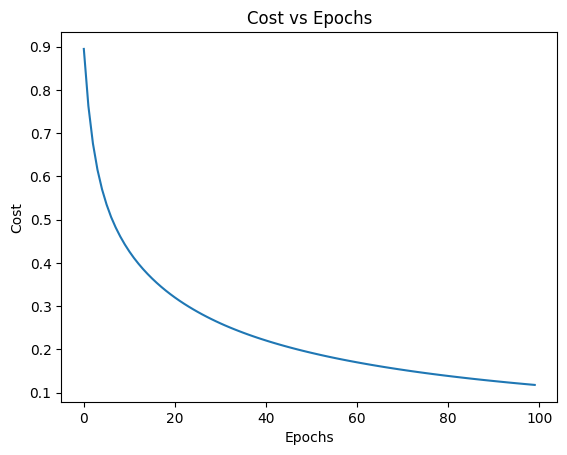

Test set accuracy: 60.546875%


In [16]:
hidden_size1 = 128                          # Size of first hidden layer
hidden_size2 = 64                           # Size of second hidden layer
epochs = 100
learning_rate = 0.001

# Train
W1, b1, W2, b2, W3, b3 = neural_network(
    X_train.T,
    y_train.reshape(1, -1),
    hidden_size1,
    hidden_size2,
    epochs,
    learning_rate
)

# Predict
predictions = predict(X_test.T, W1, b1, W2, b2, W3, b3)
accuracy = np.mean(predictions == y_test.reshape(1, -1)) * 100

print(f"Test set accuracy: {accuracy}%")

#SCATTER PLOTS

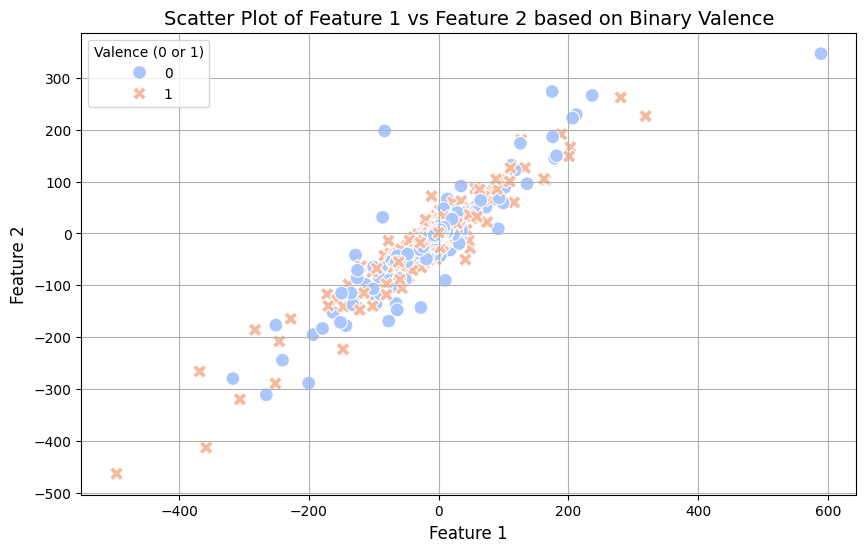

In [17]:
# Scatter plot; picking first two of 322,560 features
feature_x = X[:, 0]
feature_y = X[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_x, y=feature_y, hue=y, palette="coolwarm", style=y, s=100)

plt.title("Scatter Plot of Feature 1 vs Feature 2 based on Binary Valence", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(title="Valence")
plt.grid(True)
plt.show()

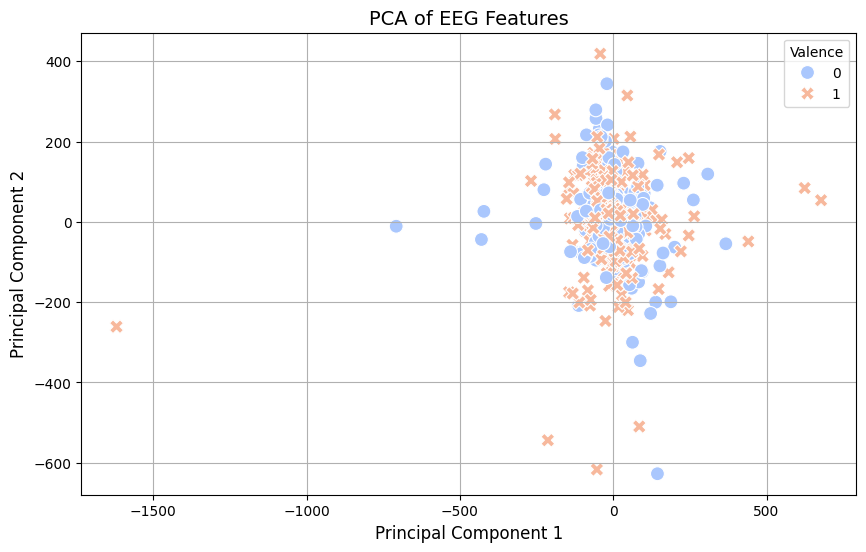

In [22]:
#PCA based scatterplot

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Valence'] = y_train

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Valence", palette="coolwarm", style="Valence", s=100, data=df_pca)

plt.title("PCA of EEG Features", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Valence")
plt.grid(True)
plt.show()
